In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from udf import score_udf, score, agg_features
import pandas as pd


In [2]:
transactions_train = pd.read_csv('data/transactions_train.csv')
transactions_train[:10]

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017
2,33172,8,11,13.887
3,33172,9,11,15.983
4,33172,10,11,21.341
5,33172,11,11,17.941
6,33172,12,11,17.726
7,33172,13,18,47.397
8,33172,13,1,220.009
9,33172,13,11,9.067


In [7]:
train_target = pd.read_csv('data/train_target.csv', index_col='client_id')
train_target[:5].reset_index()

,client_id,bins
0,24662,2
1,1046,0
2,34089,2
3,34848,1
4,47076,3


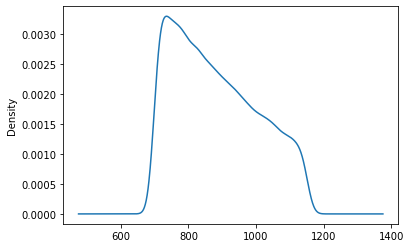

In [13]:
transactions_train = pd.read_csv('data/transactions_train.csv')
transactions_train.groupby('client_id').client_id.count().plot.kde();

In [15]:
pd.read_csv('data/small_group_description.csv')[:10]

,small_group,small_group_code
0,Зоотовары,0
1,Сетевые супермаркеты и продуктовые магазины,1
2,Обслуживание существующего автомобиля (АЗС),2
3,Оплата телефона и связи,3
4,Аптеки,4
5,Авиабилеты,5
6,Duty-free,6
7,Страховка,7
8,Спорт,8
9,Универсальные товары,9


In [31]:
transactions_train = pd.read_csv('data/transactions_train.csv')
transactions_test = pd.read_csv('data/transactions_test.csv')
train_target = pd.read_csv('data/train_target.csv', index_col='client_id')
transactions = pd.concat([transactions_train, transactions_test])
agg = agg_features(transactions)

train_df = agg[agg.index.isin(train_target.index)]
test_df = agg[~agg.index.isin(train_target.index)]

train_df.to_csv('data/agg_train.csv')
test_df.to_csv('data/agg_test.csv')

In [10]:
train_df = pd.read_csv('data/agg_train.csv', index_col='client_id')
train_df[:5].T

client_id,4,6,7,10,11
sum,28404.121000,15720.739000,53630.036000,34419.365000,26789.404000
mean,39.450168,21.535259,69.379089,48.752642,32.991877
std,73.511624,26.200397,253.261383,63.191701,107.395139
min,0.043000,0.045000,0.043000,0.045000,0.388000
max,1341.802000,315.781000,4505.971000,654.893000,2105.058000
...,...,...,...,...,...
small_group_std_195,0.000000,0.000000,0.000000,0.000000,0.000000
small_group_std_196,0.000000,0.000000,0.000000,0.000000,0.000000
small_group_std_197,0.000000,0.000000,0.000000,0.000000,0.000000
small_group_std_198,0.000000,0.000000,0.000000,0.000000,0.000000


In [35]:
from sklearn.ensemble import RandomForestClassifier
from joblib import dump

train_df = pd.read_csv('data/agg_train.csv').sort_index()
train_target = pd.read_csv('data/train_target.csv', index_col='client_id').sort_index()

m = RandomForestClassifier(n_estimators=100, oob_score=True).fit(train_df, train_target)
dump(m, 'data/rfm.dump')
m.oob_score_

0.5684666666666667

In [17]:
from pyspark.sql import SparkSession

ss = SparkSession.builder.master('local').config(
    'spark.executor.instances', '1'
).getOrCreate()

ss.sparkContext

<SparkContext master=local appName=pyspark-shell>

In [18]:
from joblib import load
m = load('data/rfm.dump')

df = ss.read.csv('data/agg_test.csv', header=True)
class_names=[f'age_group{i}' for i in range(4)]

In [19]:
%%time

scores = score(ss.sparkContext, df, m, cols_to_save=['client_id'], target_class_names=class_names).cache()
scores.count()

CPU times: user 298 ms, sys: 462 ms, total: 760 ms
Wall time: 31.1 s


20000

In [20]:
scores.show()

+----------+----------+----------+----------+---------+
|age_group0|age_group1|age_group2|age_group3|client_id|
+----------+----------+----------+----------+---------+
|      0.19|      0.02|      0.77|      0.02|        0|
|      0.07|      0.62|      0.03|      0.28|        1|
|      0.37|      0.23|      0.14|      0.26|        2|
|      0.34|      0.12|      0.08|      0.46|        3|
|       0.2|       0.2|      0.29|      0.31|        5|
|      0.21|      0.31|      0.09|      0.39|        8|
|      0.35|      0.01|       0.5|      0.14|        9|
|      0.06|      0.83|      0.02|      0.09|       15|
|      0.27|      0.18|      0.32|      0.23|       16|
|      0.33|      0.18|      0.21|      0.28|       21|
|      0.39|       0.2|      0.06|      0.35|       24|
|      0.26|      0.44|       0.1|       0.2|       30|
|       0.3|      0.34|      0.08|      0.28|       35|
|      0.21|      0.02|       0.7|      0.07|       41|
|      0.07|      0.78|      0.03|      0.12|   

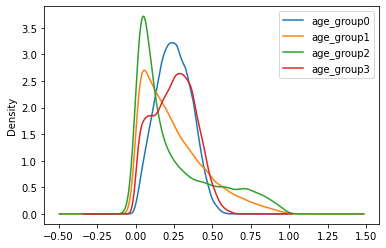

In [13]:
s_pdf = scores.toPandas()
s_pdf.plot.kde();

In [14]:
%%time

scores = score_udf(df, m, target_class_names=class_names, cols_to_save=['client_id']).cache()
scores.count()

CPU times: user 167 ms, sys: 164 ms, total: 331 ms
Wall time: 7.6 s


20000

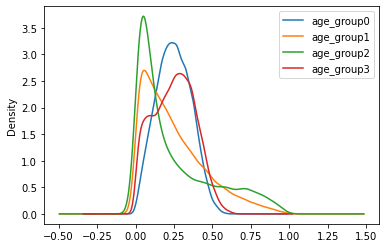

In [11]:
s_pdf = scores.toPandas()
s_pdf.plot.kde();